# Project data onto Dahlin Landscape
## Xiaonan Wang
## 07Jan2023

In [1]:
#%matplotlib nbagg
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
from os import listdir
from os.path import isfile, join
import re
import anndata
import seaborn as sns

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()

from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list(name='gene_cmap', colors=['lightgrey', 'thistle', 'red', 'darkred']) 

sc.settings.set_figure_params(dpi=80, color_map='viridis', vector_friendly=False,  dpi_save=300)

scanpy==1.8.2 anndata==0.7.8 umap==0.5.2 numpy==1.20.3 scipy==1.7.3 pandas==1.3.5 scikit-learn==1.0.1 statsmodels==0.13.1 python-igraph==0.9.8 louvain==0.7.1 pynndescent==0.5.5


In [2]:
adata = sc.read('./write/Ageing_norm.h5ad')
adata = anndata.AnnData(X=np.exp(adata.X.toarray())-1, obs=adata.obs, var=adata.var, obsm=adata.obsm)

In [3]:
ref_data = sc.read('/home/xw251/rds/rds-bg200-hphi-gottgens/users/xw251/Files/Niki_10X_data/WT_10X_data/niki_passQC_norm_10K.h5ad')
ref_data = ref_data[ref_data.obs['CellSubType'] !='Unknown',:].copy()
ref_hvg = np.genfromtxt('/home/xw251/rds/rds-bg200-hphi-gottgens/users/xw251/Files/Niki_10X_data/WT_10X_data/gene_names.txt', dtype=str)

ref_data.obs['CellSubType'] =  ref_data.obs['CellSubType'].astype('category')
ref_data.obs['CellSubType'] =ref_data.obs['CellSubType'].cat.reorder_categories(['HSCs', 'Immatur', 'Lymphoi','MEP','Megakry','Early e','Middle ','Late er', 'Basophi', 'Neutrop'])
ref_data.obs['CellSubType'] =ref_data.obs['CellSubType'].cat.rename_categories(['HSC', 'Immature', 'Lymphoid', 'MEP', 'Megakaryocyte', 'Early erythoid', 'Middle erythoid', 'Late erythoid', 'Basophil', 'Neutrophil'])

In [4]:
OLG = np.intersect1d(ref_hvg, adata.var_names)
print(len(OLG))
adata = adata[:,OLG].copy()
ref_data = ref_data[:,OLG].copy()

sc.pp.normalize_per_cell(adata, counts_per_cell_after=10000)
sc.pp.normalize_per_cell(ref_data, counts_per_cell_after=10000)

sc.pp.log1p(adata)
sc.pp.log1p(ref_data)

4658
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [5]:
print(adata.shape)
print(ref_data.shape)

(21708, 4658)
(44321, 4658)


In [6]:
# scale them together
data_comb = adata.concatenate(ref_data)
sc.pp.scale(data_comb)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [7]:
adata = anndata.AnnData(X=data_comb[data_comb.obs['batch'] == '0',:].X, obs=adata.obs, var=adata.var, obsm=adata.obsm, uns=adata.uns)
ref_data = anndata.AnnData(X=data_comb[data_comb.obs['batch'] == '1',:].X, obs=ref_data.obs, var=ref_data.var, obsm=ref_data.obsm, uns=ref_data.uns)

In [8]:
print(adata.shape)
print(ref_data.shape)

(21708, 4658)
(44321, 4658)


In [9]:
from sklearn.decomposition import PCA
pca_ = PCA(n_components=50, svd_solver='auto', random_state=0)

In [10]:
pca_.fit(ref_data.X)

PCA(n_components=50, random_state=0)

In [11]:
X_pca1 = pca_.transform(ref_data.X)
X_pca2 = pca_.transform(adata.X)

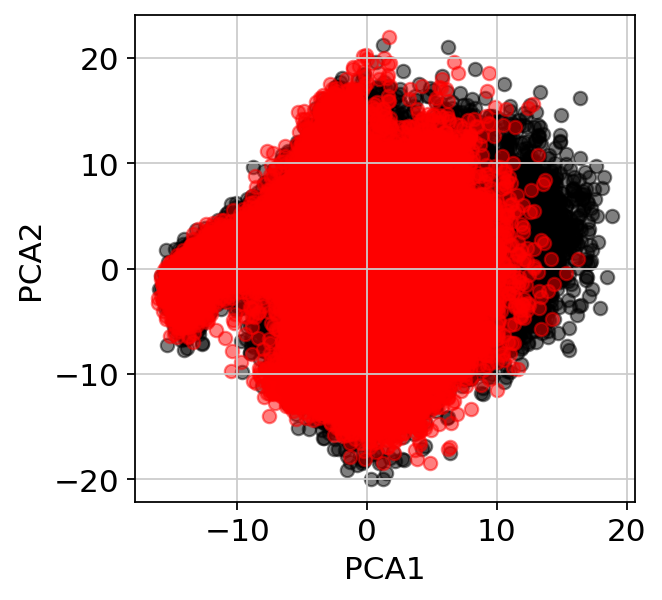

In [12]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(X_pca1[:,0], X_pca1[:,1], c='black', alpha=0.5)
plt.xlabel('PCA1')
plt.ylabel('PCA2')
ax1.scatter(X_pca2[:,0], X_pca2[:,1], c='red', alpha=0.5)
plt.show()

In [13]:
from sklearn.metrics.pairwise import euclidean_distances
D_sub = euclidean_distances(X_pca2, X_pca1)

In [14]:
print(X_pca1.shape)
print(X_pca2.shape)
print(D_sub.shape)

(44321, 50)
(21708, 50)
(21708, 44321)


In [15]:
from collections import defaultdict
cl_assigned = []
Rstore = defaultdict(list) # dictionary to store results
for i in range(D_sub.shape[0]):
    CellDis = D_sub[i,:]
    CellDis_sorted = np.argsort(CellDis)[:15]
    cl_assigned.append(np.in1d(range(len(CellDis)), CellDis_sorted))
    Rstore['MinDist'].append(np.min(CellDis[CellDis_sorted]))
    Rstore['MedianDist'].append(np.median(CellDis[CellDis_sorted]))
    Rstore['MaxDist'].append(np.max(CellDis[CellDis_sorted]))
    Rstore['SD'].append(np.std(CellDis[CellDis_sorted]))
    Rstore['Dahlin_CT'].append(ref_data[CellDis_sorted,:].obs['CellSubType'].value_counts().index[0])
Rstore = pd.DataFrame.from_dict(Rstore)
Rstore.index = adata.obs_names

In [16]:
Rstore.to_csv('Proj_results_dahlin.csv')

In [17]:
cl_assigned = np.vstack(cl_assigned)
print(cl_assigned.shape)

(21708, 44321)


In [18]:
def Obs_sublabels(ref_data, proj_data, proj_data_obs, cl_assigned, prefix):
    CT = np.unique(proj_data.obs[proj_data_obs])
    print(CT)
    for ct in CT:
        idx = proj_data.obs[proj_data_obs] == ct
        ca_new = cl_assigned[idx,:]
        ref_data.obs[prefix+'_'+ct] = np.log2(np.sum(ca_new, axis=0)+1)

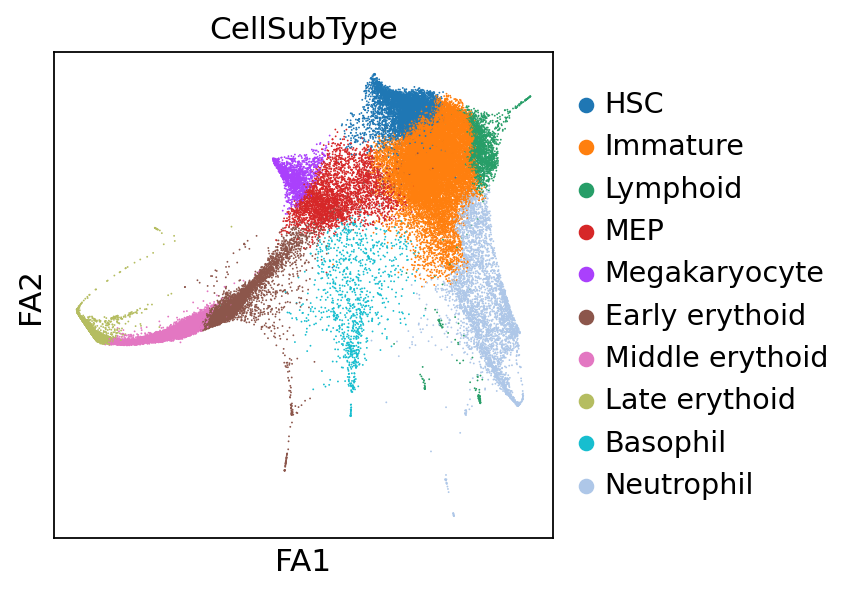

In [19]:
sc.pl.draw_graph(ref_data, color='CellSubType', legend_loc="right margin", color_map=cmap)